In [8]:
import numpy as np
from scipy.signal import savgol_filter, find_peaks, welch
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import h5py

In [62]:
def generate_noise_from_psd(frequencies, psd_values, signal_length, sampling_rate, factor):
    """
    Generate time-domain noise from a given PSD.
    
    frequencies: Array of frequency bins
    psd_values: Power spectral density values
    signal_length: Length of the time-domain signal
    sampling_rate: Sampling rate of the signal
    """
    # Number of frequency bins
    n_freqs = len(frequencies)
    
    # Generate random phases uniformly distributed between 0 and 2*pi
    random_phases = np.exp(2j * np.pi * np.random.rand(n_freqs))
    
    # Apply square root of the PSD to the random phases (for correct amplitude scaling)
    noise_freq_domain = np.sqrt(psd_values) * random_phases/factor
    
    # Symmetrize the frequency spectrum to get real-valued time-domain noise
    noise_freq_domain = np.concatenate([noise_freq_domain, np.conj(noise_freq_domain[::-1])])
    
    # Perform inverse FFT to get time-domain noise
    time_domain_noise = np.real(ifft(noise_freq_domain)) * np.sqrt(sampling_rate)
    
    # Trim or pad the noise to match the signal length
    if len(time_domain_noise) > signal_length:
        time_domain_noise = time_domain_noise[:signal_length]
    else:
        time_domain_noise = np.pad(time_domain_noise, (0, signal_length - len(time_domain_noise)))
    
    return time_domain_noise

In [46]:
def double_exp(t, A, t0, taur, taud,k):
    x = A*(1-np.exp(-(t-t0)/taur))*np.exp(-(t-t0)/taud)+k
    return np.maximum(x, 0)

In [102]:
def align_definitive(signal, window=180, polyorder=8, derivorder=1):
    signal_derivative = savgol_filter(signal, window, polyorder, derivorder)

    idxs, props = find_peaks(signal_derivative[1:-1], 0)
    
    if len(idxs) == 0 or len(props['peak_heights']) == 0:
        print("Nessun picco trovato nella derivata, allineamento non possibile.")
        return None

    try:
        if max(props['peak_heights']) <= 5 * np.std(signal_derivative):
            #print("Picco massimo nella derivata non significativo.")
            return None
    except Exception as e:
        #print(f"Errore nel calcolo del picco massimo della derivata: {e}")
        return None

    bw = 0
    max_idx = np.argmax(props['peak_heights'])
    peak_idx = idxs[max_idx]
    
    mean = max(signal_derivative)

    while mean > np.std(signal_derivative[:1000]) or mean < -np.std(signal_derivative[:1000]):
        if peak_idx - bw < 0:
            #print("Indice xmin fuori dai limiti, allineamento non possibile.")
            return None
        bw += 1
        dacalcolare = signal_derivative[peak_idx - bw:peak_idx]
        mean = np.mean(dacalcolare)

    xmin = peak_idx - bw

    if xmin >= peak_idx or xmin < 0:
        #print(f"Intervallo vuoto per np.argmin: xmin={xmin}, peak_idx={peak_idx}.")
        return None

    x_alignment = xmin + np.argmin(signal_derivative[xmin:peak_idx])

    final = signal[x_alignment - 1000:x_alignment + 19000] if x_alignment - 1000 >= 0 else None

    return xmin, x_alignment, final

In [103]:
noisy = np.genfromtxt('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/PSD.txt')

In [104]:
freq = noisy.T[0]
PSD  = noisy.T[1]

In [110]:
lenght = int(2e4)
time_domain_noise = generate_noise_from_psd(freq, PSD, lenght, int(1e8), factor=8)

In [152]:
# Example parameters for signal and noise generation
t_sample = int(1e8)  # Time step (e.g., 1 ms)
signal_length = lenght  # Number of samples for the signal
t = np.linspace(0, signal_length, signal_length)  # Time axis
dictionary = {
    'Window_lenght': [],
    'Success' : []
}
N = 1000
for w in np.arange(91,451,10):
    successfull = 0
    dictionary['Window_lenght'].append(w)
    print(w)
    for count in range(N):
        # Generate a double exponential signal with random parameters
        A = np.random.uniform(0.5, 3.0)  # Random amplitude
        t0 = np.random.uniform(800, 2300)  # Random amplitude
        signal = double_exp(t, A, t0, 47, 3323, 0.04)
        # Assuming you have already computed the PSD and frequency axis using your PSD() function
        # Example of getting the PSD and frequencies (replace with real noise data)
        # esignal_matrix = np.random.randn(10, 1000)  # Example noise events matrix
        # frequencies, scaled_psd, unscaled_psd = PSD(esignal_matrix, t_sample)
        noisy_signal = signal + time_domain_noise + np.random.normal(0, A*2/5, lenght)+3
        c = align_definitive(noisy_signal, w, 8, 1);
        if c: 
            successfull += 1        
    dictionary['Success'].append(successfull)

91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441


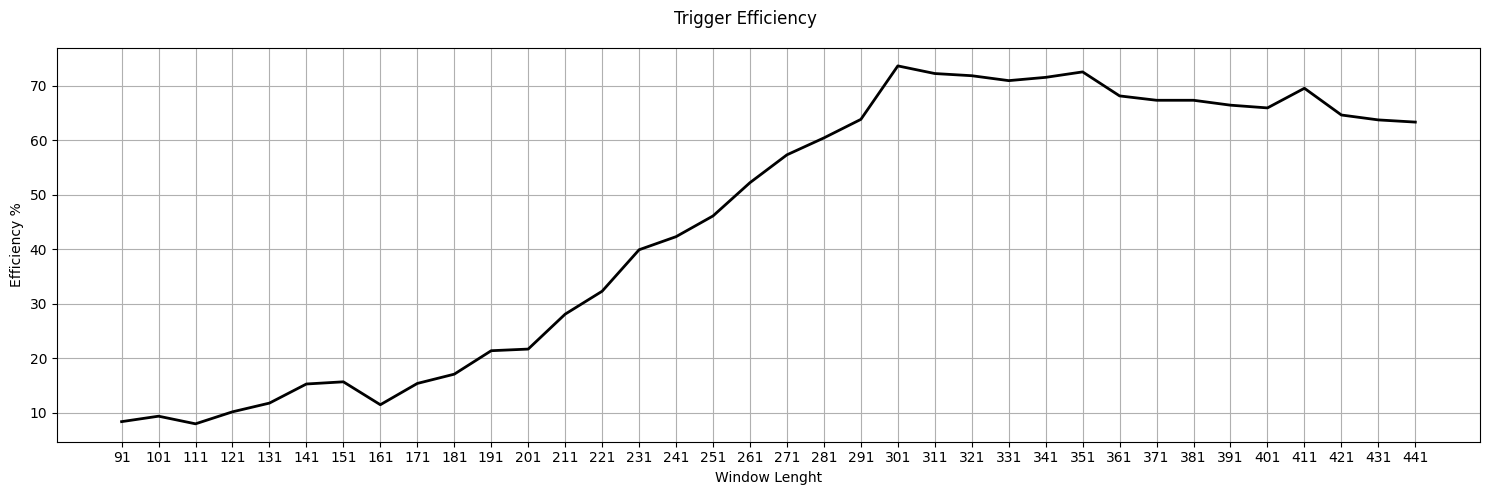

In [157]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
axs.plot(dictionary['Window_lenght'],np.array(dictionary['Success'])/N*100,linewidth=2,color='black')
axs.grid()
fig.suptitle('Trigger Efficiency')
axs.set_xlabel('Window Lenght')
axs.set_ylabel('Efficiency %')
axs.set_xticks(dictionary['Window_lenght'])
fig.tight_layout()